# Word2Vec

In [145]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [146]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
import sys
import ast
import numpy as np
import time
import scipy.sparse
from itertools import permutations, combinations
import re
import collections

## Разные задания из семинара

### Sliding window

In [148]:


def generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=True, list_compr=False, allocfirst=False):
    """
    text - list of integer numbers - ids of tokens in text
    window_size - odd integer - width of window
    vocab_size - positive integer - number of tokens in vocabulary
    ns_rate - positive integer - number of negative tokens to sample per one positive sample

    returns list of training samples (CenterWord, CtxWord, Label)
    """
    halfstep = window_size // 2
    tstart = time.perf_counter()
    n_txt = len(text)
    if naive:
        res = []
        for i in range(n_txt):
            for j in range(-halfstep, halfstep + 1):
                if halfstep != 0 and j == 0:
                    continue
                if i + j < 0 or i + j >= n_txt:
                    continue
                res.append([text[i], text[i + j], 1])
                for k in range(ns_rate):
                    res.append([text[i], np.random.randint(0, vocab_size), 0])
    elif list_compr:
        res = [[text[i], text[i + j], 1] if k == -1 else [text[i], np.random.randint(0, vocab_size), 0] 
                                           for i in range(n_txt)
                                           for j in range(-halfstep, halfstep + 1) if ((i + j >= 0 and i + j < n_txt) and ((j != 0 and halfstep > 0) or (halfstep == 0)))
                                           for k in range(-1, ns_rate) 
            ]
    elif not allocfirst:
        ndx = [[i, i + j] for i in range(n_txt) for j in range(-halfstep, halfstep + 1) if ((i + j >= 0 and i + j < n_txt) and ((j != 0 and halfstep > 0) or (halfstep == 0)))]
        n_pos = len(ndx)
        ndx = np.ravel(ndx)
        res = text[ndx].reshape(n_pos, 2)
        res = np.append(res, np.ones((n_pos, 1), dtype=int), axis=1)
        for ineg in range(ns_rate):
            res = np.append(res, res[:, :1], axis=1)
            res = np.append(res, np.random.randint(0, vocab_size, (n_pos, 1)), axis=1)
            res = np.append(res, np.zeros((n_pos, 1), dtype=int), axis=1)
        res = res.reshape((n_pos * (ns_rate + 1) , 3))

    else:
        ndx = [[i, i + j] for i in range(n_txt) for j in range(-halfstep, halfstep + 1) if ((i + j >= 0 and i + j < n_txt) and ((j != 0 and halfstep > 0) or (halfstep == 0)))]
        n_pos = len(ndx)
        ndx = np.ravel(ndx)
        res = np.zeros((n_pos, (ns_rate + 1) * 3), dtype=int)
        res[:, :2] = text[ndx].reshape(n_pos, 2)
        res[:, 2] = 1
        for ineg in range(ns_rate):
            ineg3 = 3 + ineg * 3
            res[:, ineg3] = res[:, 0]
            res[:, ineg3 + 1] = np.random.randint(0, vocab_size, n_pos)
            res[:, ineg3 + 2] = 0
        res = res.reshape((n_pos * (ns_rate + 1) , 3))

    tstop = time.perf_counter()

        
    return res, tstop - tstart



In [149]:

text = np.array([1, 0, 1, 0, 0, 5, 0, 3, 5, 5, 3, 0, 5, 0, 5, 2, 0, 1, 3])
text = np.array([ 1,  6,  1,  0, -7])
window_size = 3
vocab_size = 4
ns_rate = 1

result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate)
print(result, tm)

result3, tm =  generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, list_compr=True)
print(result3, tm)

result1, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False)
print(result1.tolist(), tm)

result2, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, allocfirst=True)
print(result2.tolist(), tm)

[[1, 6, 1], [1, 0, 0], [6, 1, 1], [6, 3, 0], [6, 1, 1], [6, 1, 0], [1, 6, 1], [1, 0, 0], [1, 0, 1], [1, 3, 0], [0, 1, 1], [0, 3, 0], [0, -7, 1], [0, 3, 0], [-7, 0, 1], [-7, 3, 0]] 0.00016350099940609653
[[1, 6, 1], [1, 1, 0], [6, 1, 1], [6, 3, 0], [6, 1, 1], [6, 1, 0], [1, 6, 1], [1, 2, 0], [1, 0, 1], [1, 0, 0], [0, 1, 1], [0, 3, 0], [0, -7, 1], [0, 2, 0], [-7, 0, 1], [-7, 0, 0]] 5.527299981622491e-05
[[1, 6, 1], [1, 0, 0], [6, 1, 1], [6, 0, 0], [6, 1, 1], [6, 2, 0], [1, 6, 1], [1, 1, 0], [1, 0, 1], [1, 2, 0], [0, 1, 1], [0, 3, 0], [0, -7, 1], [0, 3, 0], [-7, 0, 1], [-7, 2, 0]] 0.0022827960001450265
[[1, 6, 1], [1, 0, 0], [6, 1, 1], [6, 1, 0], [6, 1, 1], [6, 1, 0], [1, 6, 1], [1, 1, 0], [1, 0, 1], [1, 1, 0], [0, 1, 1], [0, 0, 0], [0, -7, 1], [0, 1, 0], [-7, 0, 1], [-7, 0, 0]] 0.000136945998747251


In [150]:
conditions = ((10, 20, 3, 2),
              (10, 20, 3, 10),
              (1000, 1000, 3, 2),
              (1000, 1000, 11, 2),
              (10000, 10000, 5, 5),
              (100000, 100000, 5, 3),
              (1000000, 1000000, 5, 3),
              )


for text_size, vocab_size, window_size, ns_rate in conditions:
    tms1, tms2, tms3, tms4 = [], [], [], []
    text = np.random.randint(0, vocab_size, text_size)

    for i in range(10):
        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate)
        tms1.append(tm)

        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, list_compr=True)
        tms2.append(tm)

        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False)
        tms3.append(tm)

        result, tm = generate_w2v_sgns_samples(text, window_size, vocab_size, ns_rate, naive=False, allocfirst=True)
        tms4.append(tm)
    print('text_size = {0}, vocab_size = {1}, window_size = {2}, ns_rate = {3}'.format(text_size, vocab_size, window_size, ns_rate))
    print('naive with 3 for loops              ', np.mean(tms1))
    print('naive with list comprehensions      ', np.mean(tms2))
    print('vector-style with np.append         ', np.mean(tms3))
    print('vector-style with preallocated array', np.mean(tms4))
    print()

text_size = 10, vocab_size = 20, window_size = 3, ns_rate = 2
naive with 3 for loops               0.00015824349957256346
naive with list comprehensions       0.0001450816003853106
vector-style with np.append          0.00011055960039811908
vector-style with preallocated array 8.247650002886075e-05

text_size = 10, vocab_size = 20, window_size = 3, ns_rate = 10
naive with 3 for loops               0.0008535080000001471
naive with list comprehensions       0.0007164869000916951
vector-style with np.append          0.0008629726999060949
vector-style with preallocated array 0.00027542190000531266

text_size = 1000, vocab_size = 1000, window_size = 3, ns_rate = 2
naive with 3 for loops               0.017699595000340195
naive with list comprehensions       0.018717837700023665
vector-style with np.append          0.0034703227000136396
vector-style with preallocated array 0.00372336139989784

text_size = 1000, vocab_size = 1000, window_size = 11, ns_rate = 2
naive with 3 for loops          

KeyboardInterrupt: ignored

### GloVe mutual occurence

In [ ]:
# from itertools import permutations
# from itertools import combinations

def generate_coocurrence_matrix(texts, vocab_size, naive=True, naive2=False, perm=False, comb_set=False):
    """
    texts - list of lists of ints - i-th sublist contains identifiers of tokens in i-th document
    vocab_size - int - size of vocabulary
    returns scipy.sparse.dok_matrix
    """
    tstart = time.perf_counter()
    mutual_occurence = scipy.sparse.dok_matrix((vocab_size, vocab_size), dtype=int)
    if naive:
        for text in texts:
            dk_loc = scipy.sparse.dok_matrix((vocab_size, vocab_size), dtype=int)
            for i, vi in enumerate(text):
                for j, vj in enumerate(text):
                    if i <= j or vi == vj:
                        continue
                    dk_loc[vi, vj] = 1
                    dk_loc[vj, vi] = 1
            mutual_occurence += dk_loc
    elif naive2:
        for i in range(vocab_size):
            for j in range(vocab_size):
                if i <= j:
                    continue
                for text in texts:
                    if i in text and j in text:
                        mutual_occurence[i, j] += 1
                        mutual_occurence[j, i] += 1
    elif perm:
        for text in texts:
            cur_comb = set(permutations(text, 2))
            for vi, vj in cur_comb:
                if vi == vj:
                    continue
                mutual_occurence[vi, vj] += 1
    elif comb_set:
        for text in texts:
            combs = combinations(set(text), 2)
            for vi, vj in combs:
                mutual_occurence[vi, vj] += 1
                mutual_occurence[vj, vi] += 1
    tstop = time.perf_counter()
    return mutual_occurence, tstop - tstart


text = [[0, 2, 2, 2, 0, 0], [1, 1, 2, 1, 1], [2, 2, 1, 1]]
vocab_size = 3

result, tm = generate_coocurrence_matrix(text, vocab_size)
print(result.A)
result, tm = generate_coocurrence_matrix(text, vocab_size, naive=False, perm=True)
print(result.A)

In [ ]:
conditions = ((10, 10, 10),
              (10, 1000, 10),
              (1000, 10, 10),
              (10, 10, 1000),
              (10, 10, 10000),
              (100, 1000, 1000),
              (100, 100, 1000),
              (10, 10000, 10000),
              (100, 1000, 100000),
              )

for n_texts, text_len, vocab_size in conditions:
    tms1, tms2, tms3, tms4 = [], [], [], []
    text = np.random.randint(0, vocab_size, (n_texts, text_len))
    for i in range(10):
        res, tm1 = generate_coocurrence_matrix(text, vocab_size)
        tms1.append(tm1)
        res, tm2 = generate_coocurrence_matrix(text, vocab_size, naive=False, naive2=True)
        tms2.append(tm2)
        res, tm3 = generate_coocurrence_matrix(text, vocab_size, naive=False, perm=True)
        tms3.append(tm3)
        res, tm4 = generate_coocurrence_matrix(text, vocab_size, naive=False, comb_set=True)
        tms4.append(tm4)
    print('Number of texts = {0}, text size = {1}, vocabulary size = {2}'.format(n_texts, text_len, vocab_size))
    print('Naive iteration, iterating over texts and words inside of them', np.mean(tms1))
    print('Naive iteration, iterating over words and then over texts', np.mean(tms2))
    print('With itertools.permutations', np.mean(tms3))
    print('With itertools.combinations over a set', np.mean(tms4))
    print('')



# Word embeddings

### Tokenizers

In [ ]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
lemma = nltk.wordnet.WordNetLemmatizer()

sno = nltk.stem.SnowballStemmer('english')

stopwords_en = stopwords.words('english')

In [279]:
TOKEN_RE = re.compile(r'[\w\d]+')
TOKEN_RE = re.compile(r'[\w]+')
# TOKEN_RE = re.compile(r'[^\d\W]+|[\d]*\.[\d]+|-[\d]*\.[\d]+|-[\d]+|[\d]+|\.[\d]+|[^\s]')

def tokenize_text_simple_regex(txt, min_token_size=3, ngram=1):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    if ngram <= 1:
        return [token for token in all_tokens if len(token) >= min_token_size]
    else:
        tokenized = [token for token in all_tokens if len(token) >= min_token_size]
        return [tuple(tokenized[i: i + ngram]) for i in range(0, len(tokenized), ngram)]

def tokenize_text_lemmatized(txt, min_token_size=3, ngram=1):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    lemmatized = [lemma.lemmatize(token) for token in all_tokens]
    if ngram <= 1:
        return list(filter(lambda x: (len(x) >= min_token_size) & (x not in stopwords_en), lemmatized))
    else:
        lemmatized = list(filter(lambda x: len(x) >= min_token_size, lemmatized))
        return [tuple(lemmatized[i: i + ngram]) for i in range(0, len(lemmatized), ngram)]


def tokenize_text_stemmed(txt, min_token_size=3, ngram=1):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    stemmed = [sno.stem(token) for token in all_tokens]
    if ngram <= 1:
        return list(filter(lambda x: len(x) >= min_token_size, stemmed))
    else:
        stemmed = list(filter(lambda x: len(x) >= min_token_size, stemmed))
        return [tuple(stemmed[i: i + ngram]) for i in range(0, len(stemmed), ngram)]


# def character_tokenize(txt):
#     return list(txt)


# def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
#     return [tokenizer(text, **tokenizer_kwargs) for text in texts]


# def add_fake_token(word2id, token='<PAD>'):
#     word2id_new = {token: i + 1 for token, i in word2id.items()}
#     word2id_new[token] = 0
#     return word2id_new


# def texts_to_token_ids(tokenized_texts, word2id):
#     return [[word2id[token] for token in text if token in word2id]
#             for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None, use_pmi_filter=False, pmi_voc_prev=None, pmi_wl_matrix=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1
    
    # убрать слишком редкие и слишком частые слова
    
    if use_pmi_filter and pmi_wl_matrix is not None and pmi_voc_prev is not None:
        # pmi_std_bad = (np.std(pmi_wl_matrix, axis=1) >= 1.5)
        pmi_median_bad = (np.median(pmi_wl_matrix, axis=1) >= 0.5)
        word_counts = {word: cnt for word, cnt in word_counts.items()
                       if cnt >= min_count and cnt / doc_n <= max_doc_freq 
                       and pmi_median_bad[pmi_voc_prev[word]]}
    else:
        word_counts = {word: cnt for word, cnt in word_counts.items()
                       if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # # нормируем частоты слов
    word2freq = np.array([cnt  for _, cnt in sorted_word_counts], dtype='float32')  # cnt / doc_n

    return word2id, word2freq


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=None, pmi_wl_matrix=None, scalers=None):
    assert mode in {'tfidf', 'idf', 'tf', 'bin', 'ltfidf', 'ltfpmi', 'tfidfnew', 'ltfidfnew'}
    assert scale in {'minmax', 'rownorm', 'std', None}
    n_docs = len(tokenized_texts)
    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        # result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(n_docs / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(n_docs / word2freq)  # разделить каждый столбец на вес слова
        
    elif mode == 'ltfidf':
        result = (result.multiply(1 / result.sum(1))).log1p()
        result = result.multiply(n_docs / word2freq)

    elif mode == 'ltfpmi':
        result = (result.multiply(1 / result.sum(1))).log1p()
        result = result.multiply(np.amax(pmi_wl_matrix, axis=0))

    elif mode == 'tfidfnew':
        result = result.tocsr()
        idf = np.log((n_docs + 1)/ (word2freq + 1)) + 1
        # result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(idf)  # разделить каждый столбец на вес слова
        
    elif mode == 'ltfidfnew':
        result = result.tocsr()
        idf = np.log((n_docs + 1)/ (word2freq + 1)) + 1
        # result = (result.multiply(1 / result.sum(1))).log1p()
        result = result.log1p()
        result = result.multiply(idf)
  
    if scale == 'std':
        result = result.tocsc()
        if scalers is None:
            rstd = 1. / result.A.std(axis=0)
            result = result.multiply(rstd)
            return result.tocsr(), None, rstd
        else:
            result = result.multiply(scalers[1])
    elif scale == 'minmax':
        result = result.tocsc()
        if scalers is None:
            rmin = result.min()
            result -= rmin
            rmax = 1. / (result.max() + 1e-6)
            result = result.multiply(rmax)
            return result.tocsr(), rmin, rmax
        else:
          result -= scalers[0]
          result = result.multiply(scalers[1])
    elif scale == 'rownorm':
        result = result.tocsr()
        rown = np.expand_dims(1. / scipy.sparse.linalg.norm(result, axis=1), axis=1)
        result = result.multiply(rown)
        
    return result.tocsr()



# PAD_TOKEN = '__PAD__'
# NUMERIC_TOKEN = '__NUMBER__'
# NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)


# def replace_number_nokens(tokenized_texts):
#     return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
#             for text in tokenized_texts]

## Загрузка данных и подготовка корпуса

In [280]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

110 grams (2 large) eggs
1/2 teaspoon crushed fennel seeds
2 ounces rendered chicken fat
3 grams kosher salt (1 teaspoon)
2 tablespoons soy sauce
2 bay leaves
5 tablespoons freshly squeezed lemon juice
2 tablespoons salmon caviar
1/4 cup chopped fresh Italian parsley
1 cup arborio rice


In [194]:
# for i in range(len(train_source)):
#     if 'bacon' in train_source[i]:
#       print(train_source[i])

In [281]:
# токенизируем
train_tokenized = tokenize_corpus(train_source, tokenizer=tokenize_text_lemmatized)
test_tokenized = tokenize_corpus(test_source, tokenizer=tokenize_text_lemmatized)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

110 gram large egg
teaspoon crushed fennel seed
ounce rendered chicken fat
gram kosher salt teaspoon
tablespoon soy sauce
bay leaf
tablespoon freshly squeezed lemon juice
tablespoon salmon caviar
cup chopped fresh italian parsley
cup arborio rice


In [282]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2135
[('<PAD>', 0), ('cup', 1), ('tablespoon', 2), ('teaspoon', 3), ('chopped', 4), ('salt', 5), ('pepper', 6), ('pound', 7), ('ground', 8), ('oil', 9)]


In [283]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

1152 58 18 33
3 101 197 61
13 870 46 159
58 56 5 3
2 122 55
82 25
2 12 221 32 28
2 257 610
1 4 10 142 39
1 388 72


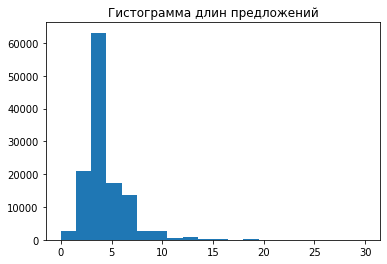

In [284]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [285]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([1152,   58,   18,   33,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [ ]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

* Помним, что совместная_встречаемость ~= W * D. То есть каждый раз, считая w_i*d_j, мы берем аппроксимацию совместной встречаемости двух слов. Как бы сравниваем их контексты.

### Model from the task

In [236]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        # nn.Embedding is a simple lookup table that stores embeddings of a fixed dictionary and size
        # Variables:
        # Embedding.weight (Tensor) – the learnable weights of the module of shape (num_embeddings, embedding_dim) 
        # initialized from N(0,1) distribution (not good for word2vec!)
        
        # center_embedding, or w, dim(w) = (voc_size, emb_size)
        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0  # padding, тк у нас в словаре нулевой вектор -- это ничто. Вот поэтому нулевому вектору тут нули сообщаем. Он не будет обучаться.

        # context_embedding, or d, dim(d) = (emb_size, voc_size)
        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        # batch matrix multiplication
        # Получаем набор матриц, содержащих оценку близости между парами токенов в одном предложении. Как бы по матрице на предложение. 
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        # И преобразуем эти оценки в вероятности (сигмоида в 0,1 преобразует):
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе (парам вне маски зануляем вероятность)
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))  # маска размножится на все матрицы в батче

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        # тут уже без сигмоиды в начале
        # сравниваем с НУЛЯМИ => отрицательные примеры
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

### Modified model

In [263]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, emb_size2, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        # nn.Embedding is a simple lookup table that stores embeddings of a fixed dictionary and size
        # Variables:
        # Embedding.weight (Tensor) – the learnable weights of the module of shape (num_embeddings, embedding_dim) 
        # initialized from N(0,1) distribution (not good for word2vec!)
        
        # center_embedding, or w, dim(w) = (voc_size, emb_size)
        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0  # padding, тк у нас в словаре нулевой вектор -- это ничто. Вот поэтому нулевому вектору тут нули сообщаем. Он не будет обучаться.

        self.m_center1 = nn.Sequential(nn.Linear(emb_size, emb_size2))
                                        # nn.ReLU(),
                                        # nn.Linear(emb_size2, emb_size2))
        self.m_center1[0].weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size2)
        # self.m_center1[2].weight.data.uniform_(-1.0 / emb_size2, 1.0 / emb_size2)
        
        # context_embedding, or d, dim(d) = (emb_size, voc_size)
        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0
        self.m_context1 = nn.Sequential(nn.Linear(emb_size, emb_size2))
                                        # nn.ReLU(),
                                        # nn.Linear(emb_size2, emb_size2))
        self.m_context1[0].weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size2)
        # self.m_context1[2].weight.data.uniform_(-1.0 / emb_size2, 1.0 / emb_size2)

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.m_center1(self.center_emb(sentences))  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.m_context1(self.context_emb(sentences)).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        # batch matrix multiplication
        # Получаем набор матриц, содержащих оценку близости между парами токенов в одном предложении. Как бы по матрице на предложение. 
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        # И преобразуем эти оценки в вероятности (сигмоида в 0,1 преобразует):
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе (парам вне маски зануляем вероятность)
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))  # маска размножится на все матрицы в батче

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.m_context1(self.context_emb(negative_words)).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        # тут уже без сигмоиды в начале
        # сравниваем с НУЛЯМИ => отрицательные примеры
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [332]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, 25, MAX_SENTENCE_LEN,
                                          radius=4, negative_samples_n=150)

In [345]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=5,
                                            batch_size=100,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 1254 итераций, 60.89 сек
Среднее значение функции потерь на обучении 0.10014250699246519
Среднее значение функции потерь на валидации 0.09895034414130958
Новая лучшая модель!

Эпоха 1
Эпоха: 1254 итераций, 61.45 сек
Среднее значение функции потерь на обучении 0.0984719876716867
Среднее значение функции потерь на валидации 0.10020770409514913

Эпоха 2
Эпоха: 1254 итераций, 62.38 сек
Среднее значение функции потерь на обучении 0.09797019799621672
Среднее значение функции потерь на валидации 0.09801960513549667
Новая лучшая модель!

Эпоха 3
Эпоха: 1254 итераций, 62.90 сек
Среднее значение функции потерь на обучении 0.09773958565301873
Среднее значение функции потерь на валидации 0.09959662524242384

Эпоха 4
Эпоха: 1254 итераций, 64.17 сек
Среднее значение функции потерь на обучении 0.09757022569149115
Среднее значение функции потерь на валидации 0.09914317725704062
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.



In [268]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), './stepik-dl-nlp/models/sgns.pth')

In [269]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('./stepik-dl-nlp/models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [346]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [347]:
embeddings.most_similar('chicken')

[('chicken', 0.9999292),
 ('breast', 0.6067734),
 ('thigh', 0.57988137),
 ('stock', 0.57520866),
 ('veal', 0.5749309),
 ('turkey', 0.56982243),
 ('broth', 0.55802584),
 ('low', 0.5220782),
 ('beef', 0.5125303),
 ('boneless', 0.50200784)]

In [348]:
embeddings.most_similar('tuna')

[('tuna', 0.9999422),
 ('albacore', 0.5383381),
 ('yellowfin', 0.42809072),
 ('salmon', 0.42722157),
 ('steak', 0.41932508),
 ('dark', 0.4119804),
 ('filleted', 0.4077516),
 ('beef', 0.40425098),
 ('codfish', 0.37810814),
 ('fillet', 0.37209883)]

In [349]:
embeddings.most_similar('bacon')

[('bacon', 0.99993837),
 ('pancetta', 0.61807024),
 ('slab', 0.614483),
 ('ham', 0.6047892),
 ('prosciutto', 0.5721566),
 ('smoked', 0.5295126),
 ('pork', 0.5073473),
 ('smithfield', 0.4552974),
 ('unsmoked', 0.45243314),
 ('hock', 0.45130658)]

In [350]:
embeddings.most_similar('oil')

[('oil', 0.99992055),
 ('olive', 0.718619),
 ('canola', 0.6817753),
 ('virgin', 0.66168463),
 ('grapeseed', 0.6565249),
 ('neutral', 0.5947835),
 ('safflower', 0.56877834),
 ('sesame', 0.56015867),
 ('peanut', 0.52263623),
 ('frying', 0.49860206)]

In [351]:
embeddings.most_similar('sodium')

[('sodium', 0.9999566),
 ('low', 0.684923),
 ('soy', 0.5956183),
 ('reduced', 0.5458027),
 ('tamari', 0.4993348),
 ('broth', 0.49894872),
 ('stock', 0.48982346),
 ('sauce', 0.4640439),
 ('homemade', 0.44424206),
 ('lowfat', 0.4421827)]

In [352]:
embeddings.most_similar('tomato')

[('tomato', 0.9999264),
 ('plum', 0.6574494),
 ('canned', 0.6014982),
 ('ripe', 0.5895911),
 ('seeded', 0.5348601),
 ('mango', 0.513061),
 ('stewed', 0.49023747),
 ('marzano', 0.46967405),
 ('avocado', 0.4644082),
 ('rom', 0.4436243)]

In [353]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 1.1905001),
 ('cheese', 1.0087551),
 ('gruyere', 0.7649254),
 ('fontina', 0.7374735),
 ('reduced', 0.6934726),
 ('percent', 0.6849265),
 ('swiss', 0.6712853),
 ('monterey', 0.6643499),
 ('jack', 0.65129864),
 ('mozzarella', 0.64763993)]

In [354]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'cookie', 'matcha', 'coffee', 'sausage', 'wine', 
              'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao', 'bacon', 'salt', 'chorizo', 'chicken', 'veal', 'tea', 'herring', 
              'fat', 'butter', 'dough', 'yeast', 'potato', 'gouda', 'pasta', 'egg', 'cheese', 'oil']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(37, 100)


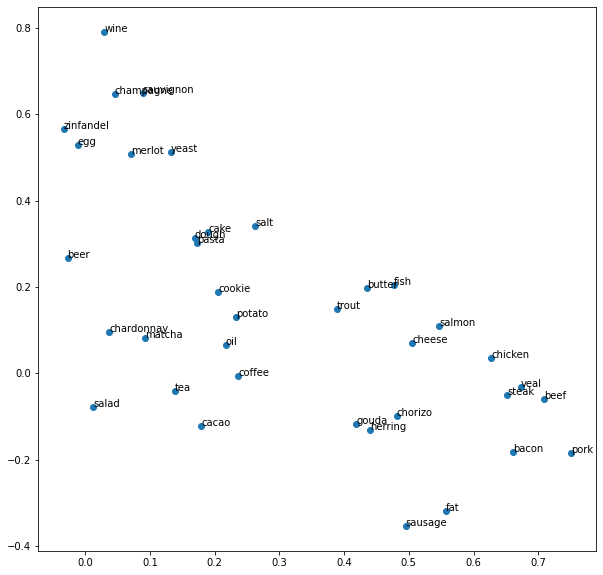

In [355]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

Добавление слоев сильно уменьшает функцию потерь, но в плане смысла особо ничего не привносит. Попробовала еще лемматизацию для большей логичности.
В целом, корпус показался мне очень ограниченным, некоторые слова имели маленькое расстояние со своими частными описаниями, которые не равным им по смыслу. Это не удивительно, ведь в исходнике это просто таблица с описанием ингридиентов с комментариями. И скорее всего контекст для некоторых слов сдвинут вправо, тк в таблице описываемое слово (ингридиент) может быть левее остальных. Некоторые вещи прямо очевидно обучались в зависимости от очень ограниченного контекста. Так, виды мяса и некоторая рыба скорее всего рядом из-за глаголов или описаний подготовки, количества и специй. Растительное масло иногда классифицировалось рядом с напитками. Обычное масло иногда было с растительным, а иногда с картошкой (потому что их жарят друг на друге и режут похожими кусочками). В общем, странное ощущение осталось. Gensim давал не более осмысленные результаты в графиках, но похожие слова были более адекватными.
Редкие слова типа селедки совсем в случайных местах появлялись. Еще я во вроде бы нормальной модели получила для "bacon" максимально похожее "vegan"...


## Обучение Word2Vec с помощью Gensim

In [299]:
import gensim

In [300]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [301]:
word2vec.wv.most_similar('chicken')

[('pheasant', 0.7331377863883972),
 ('duck', 0.7282923460006714),
 ('simmering', 0.713661789894104),
 ('capon', 0.7025219202041626),
 ('neck', 0.6982988715171814),
 ('thigh', 0.6884560585021973),
 ('gizzard', 0.6864532828330994),
 ('turkey', 0.6811442375183105),
 ('breast', 0.6788679361343384),
 ('drumstick', 0.6776902675628662)]

In [305]:
word2vec.wv.most_similar('sodium')

[('low', 0.8853210210800171),
 ('reduced', 0.842971920967102),
 ('tamari', 0.7666234374046326),
 ('rich', 0.7603530883789062),
 ('defatted', 0.7431867122650146),
 ('manis', 0.7080501317977905),
 ('simmering', 0.7078827023506165),
 ('worcestershire', 0.695085883140564),
 ('hoisin', 0.6901553869247437),
 ('homemade', 0.6866335272789001)]

In [306]:
word2vec.wv.most_similar('oil')

[('grapeseed', 0.7725487351417542),
 ('canola', 0.7514982223510742),
 ('oiling', 0.7232344150543213),
 ('neutral', 0.7227904796600342),
 ('safflower', 0.7167354226112366),
 ('drizzle', 0.7137271165847778),
 ('olive', 0.6959928274154663),
 ('virgin', 0.691914975643158),
 ('frying', 0.6702783107757568),
 ('grilling', 0.6701228618621826)]

In [307]:
word2vec.wv.most_similar('bacon')

[('slab', 0.806563675403595),
 ('pancetta', 0.7539657354354858),
 ('prosciutto', 0.7504619359970093),
 ('ham', 0.725888192653656),
 ('unsmoked', 0.7017194628715515),
 ('canadian', 0.6934816241264343),
 ('lardons', 0.6862063407897949),
 ('chorizo', 0.68161940574646),
 ('belly', 0.6406422853469849),
 ('virginia', 0.6391003131866455)]

In [308]:
word2vec.wv.most_similar('herring')

[('atlantic', 0.8508036732673645),
 ('whitefish', 0.8391577005386353),
 ('haddock', 0.8389685153961182),
 ('bluefish', 0.8310828804969788),
 ('pike', 0.8306839466094971),
 ('sturgeon', 0.8265160322189331),
 ('pompano', 0.8184292316436768),
 ('alaskan', 0.8154593706130981),
 ('mahi', 0.8147493004798889),
 ('blackfish', 0.813718318939209)]

In [302]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

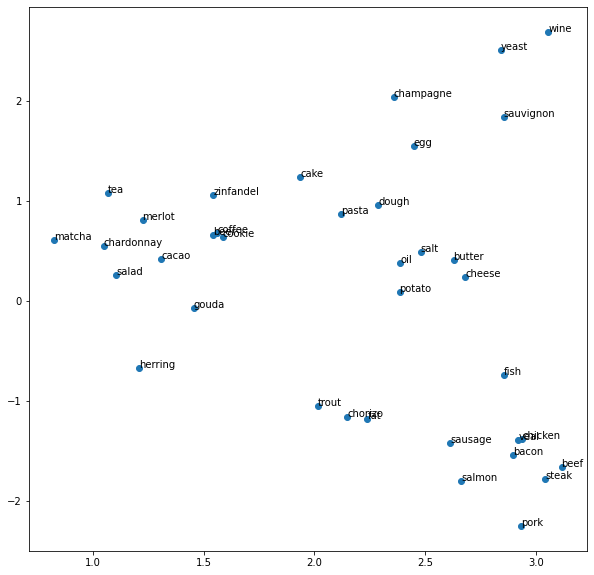

In [303]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [325]:
import gensim.downloader as api

In [326]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [327]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [328]:
pretrained.most_similar('cheese')

[('cheeses', 0.7789000272750854),
 ('cheddar', 0.7627596855163574),
 ('goat_cheese', 0.7297402620315552),
 ('Cheese', 0.7286962866783142),
 ('cheddar_cheese', 0.7255136966705322),
 ('Cheddar_cheese', 0.6943708658218384),
 ('mozzarella', 0.6805709600448608),
 ('cheddar_cheeses', 0.6694672703742981),
 ('Camembert', 0.6623163223266602),
 ('gruyere', 0.6615148186683655)]

In [ ]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609435319900513),
 ('girl', 0.6139994263648987),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077576637268066),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696184158325195),
 ('person', 0.48637545108795166)]

In [330]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

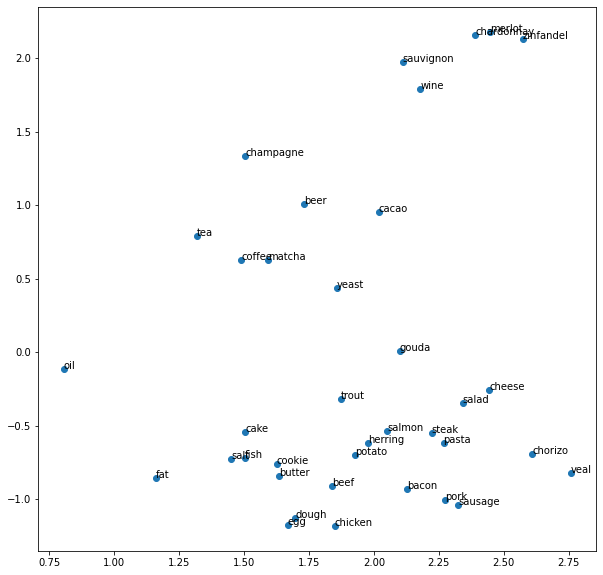

In [331]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают